# Continuous interactions

#### Adapted from chapter 8 of Statistical Rethinking. The morale of this story is that continous interactions are hard to interpret.

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az
import seaborn as sns

In [2]:
def proc_data():
    data = pd.read_csv(os.path.join(os.getcwd(),r"data/tulips.csv"), delimiter=";")
    data['blooms_std'] = data.blooms/np.max(data.blooms)
    data['water_cent'] = data.water - np.mean(data.water)
    data['shade_cent'] = data.shade - np.mean(data.shade)
    return data


In [3]:
d = proc_data()

In [5]:
d.head()

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
0,a,1,1,0.00,0.000000,-1.0,-1.0
1,a,1,2,0.00,0.000000,-1.0,0.0
2,a,1,3,111.04,0.307029,-1.0,1.0
3,a,2,1,183.47,0.507300,0.0,-1.0
4,a,2,2,59.16,0.163579,0.0,0.0


#### We are interested in predicting blooms. Since both light and water help plants grow and produce blooms, it stands to reason that the independent effect of each will be to produce bigger blooms. But we’ll also be interested in the interaction between these two variables. In the absence of light, for example, it’s hard to see how water will help a plant—photosynthesis depends upon both light and water. Likewise, in the absence of water, sunlight does a plant little good. One way to model such aninterdependency is to use an interaction effect.

#### Let's estimate two models, first a main effects model with the following DAG:
####                                W ---> B <--- S
#### With the following model specification:
$$ B_{i} \sim Normal(\mu_{i}, \sigma)$$

$$ \mu_{i} = \alpha + \beta_{w}(W_{i}-\bar{W}) + \beta_{s}(S_{i} - \bar{S})$$

$$ \alpha \sim Normal(0.5, 1)$$
$$ \beta_{w} \sim Normal(0, 1)$$
$$ \beta_{s} \sim Normal(0, 1)$$



#### Centering the prior for α at 0.5 implies that, when both water and shade are at their mean values, the model expects blooms to be halfway to the observed maximum. The two slopes are centered on zero, implying no prior information about direction. This is obviously less information than we have—basic botany informs us that water should have a positive slope and shade a negative slope. But these priors allow us to see which trend the sample shows, while still bounding the slopes to reasonable values.

#### The standard deviations are far too broad in this setting. We want $\alpha$ to be greater than zero and less than one, but the current prior assigns most of the probability outside of that range:

In [18]:
def get_probs(norm_kwargs={}): 
    a = stats.norm.rvs(**norm_kwargs)
    return np.sum((a < 0) | (a > 1))/len(a)

In [19]:
get_probs({'size': 10_000, 'loc':0.5, 'scale': 1})

0.6145

In [20]:
# now with a tigher scale
get_probs({'size': 10_000, 'loc':0.5, 'scale': 0.25})

0.0457

#### What about those slopes? What would a very strong effect of water and shade look like? How big could those slopes be in theory? The range of both water and shade is 2—from −1 to 1 is 2 units. To take us from the theoretical minimum of zero blooms on one end to the observed maximum of 1—a range of 1 unit—on the other would require a slope of 0.5 from either variable—0.5 × 2 = 1. So if we assign a standard deviation of 0.25 to each, then 95% of the prior slopes are from −0.5 to 0.5, so either variable could in principle account for the entire range, but it would be unlikely. Remember, the goals here are to assign weakly informative priors to discourage overfitting—impossibly large effects should be assigned low prior probability—and also to force ourselves to think about what the model means.

#### So instead try:
$$ \alpha \sim Normal(0.5, 0.25)$$
$$ \beta_{w} \sim Normal(0, 0.25)$$
$$ \beta_{s} \sim Normal(0, 0.25)$$


In [21]:
with pm.Model() as model_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    
    mu = a + bw*d.water_cent + bs*d.shade_cent
    sigma = pm.Exponential('sigma', 1)
    
    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d.blooms_std)
    
    m_8_4_trace = pm.sample()
    m_8_4_posterior = pm.sample_posterior_predictive(m_8_4_trace, var_names=["a", "bw", "bs"])

<ipython-input-21-6fce0c61827b>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_8_4_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [22]:
pm.summary(m_8_4_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.360,0.035,0.297,0.428,0.000,0.0,5399.0,3035.0,1.0
bw,0.204,0.042,0.122,0.280,0.001,0.0,5257.0,2891.0,1.0
bs,-0.112,0.042,-0.195,-0.038,0.001,0.0,4150.0,2893.0,1.0
sigma,0.177,0.028,0.129,0.228,0.001,0.0,3128.0,2648.0,1.0


#### Before we look at the posterior of the above model, let's define the interaction model too:

$$\mu_{i} = \alpha + \gamma_{w, i} W_{i} + \beta_{s}S_{i}$$
$$\gamma_{w, i} = \beta_{w} + \beta_{WS}S_{i}$$

#### Where $\gamma_{w, i}$ is the slope defining how quickly blooms change with water level. $\beta_{w}$ is the rate of change when shade is at it's mean value and  $\beta_{WS}$ is the rate of change in $\gamma_{w, i}$ as shade changes. Equivalently:

$$B_{i} \sim Normal(\mu_{i}, \sigma)$$

$$\mu_{i} = \alpha + (\beta_{w} + \beta_{WS}S_{i})W_{i} + \beta_{s}S_{i} = \alpha + \beta_{w}W_{i} + \beta_{s}S_{i} +  \beta_{WS}S_{i}W_{i} $$

#### The last thing we need is a prior for this new interaction parameter, βWS. This is hard, because these epicycle parameters don’t have clear natural meaning. Still, implied predictions help. Suppose the strongest plausible interaction is one in which high enough shade makes water have zero effect. That implies: 
$$\gamma_{W,i} = \beta_{w} + \beta_{WS}Si = 0 $$
#### If we set Si = 1 (the maximum in the sample), then this means the interaction needs to be the same magnitude as the main effect, but reversed: βWS = −βW. That is largest conceivable interaction. So if we set the prior for βWS to have the same standard deviation as βW, maybe that isn’t ridiculous

In [30]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)
    
    mu = a + bw*d.water_cent + bs*d.shade_cent + bws*d.water_cent*d.shade_cent
    sigma = pm.Exponential('sigma', 1)
    
    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d.blooms_std)
    
    m_8_5_trace = pm.sample()
    m_8_5_posterior = pm.sample_posterior_predictive(m_8_5_trace, var_names=["a", "bw", "bs", "bws"])

<ipython-input-30-0602f8c2d7fa>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_8_5_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Triptych plot

#### We want each plot to show the bivariate relationship between water and blooms, as predicted by the model. Each plot will plot predictions for a different value of shade. For this example, it is easy to pick which three values of shade to use, because there are only three values: −1, 0, and 1. But more generally, you might use a representative low value, the median, and a representative high value.

In [34]:
def triptych_plot(model_two_tuple):
    
    model_obj1, model_obj2 = model_two_tuple
    
    _, axs = plt.subplots(2, 3, figsize=[9,5], sharey=True, sharex=True, constrained_layout=True)

    n_lines = 20
    pred_x = np.array([-1, 1])

    for i, shade in enumerate([-1, 0, 1]):
        idx = d.shade_cent == shade
        for ax in axs[:, i]:
            ax.scatter(d.loc[idx, "water_cent"], d.loc[idx, "blooms_std"])
        ax = axs[0, i]
        ax.set_title(f"m_8_4 posterior: shade = {shade:.0f}", fontsize=11)
        pred_y = (
            model_obj1["a"][:n_lines] + model_obj1["bw"][:n_lines]*pred_x.reshape(-1,1)
            + model_obj1["bs"][:n_lines]*shade)
        ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
        ax = axs[1, i]
        ax.set_title(f"m_8_5 posterior: shade = {shade:.0f}", fontsize=11)
        pred_y = (
            model_obj2["a"][:n_lines] + model_obj2["bw"][:n_lines]*pred_x.reshape(-1,1)
            + model_obj2["bs"][:n_lines]*shade + model_obj2["bws"][:n_lines]*pred_x.reshape(-1, 1)*shade)
        ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    for ax in axs.flat:
        if ax.is_first_col():
            ax.set_ylabel("blooms")
        if ax.is_last_row():
            ax.set_xlabel("water")


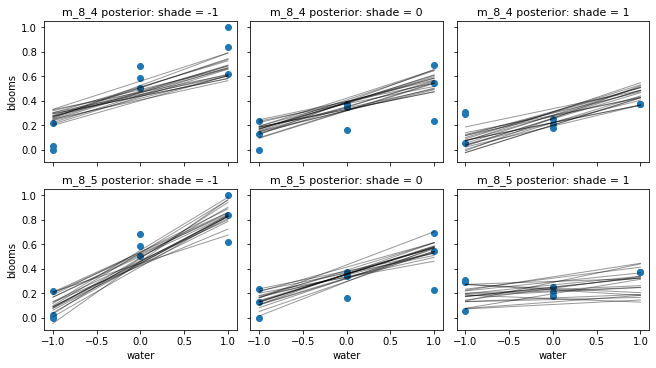

In [35]:
triptych_plot((m_8_4_posterior, m_8_5_posterior))

#### The top row does not include the interaction term whilst the bottom row does. The top model believes that water helps with positive slops whilst shade hurts, we can see the lines sinking as we go from right to left across the range of values for shade. The slope for water does not vary across shade levels. In the interaction model we see that the effect of water does decrease with shade levels, the lines get flatter.

#### We can use the same technique to plot prior predictive simulations in order to evaluate our earlier priors.

In [39]:
with model_8_4:
    m_8_4_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])

with m_8_5:
    m_8_5_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])

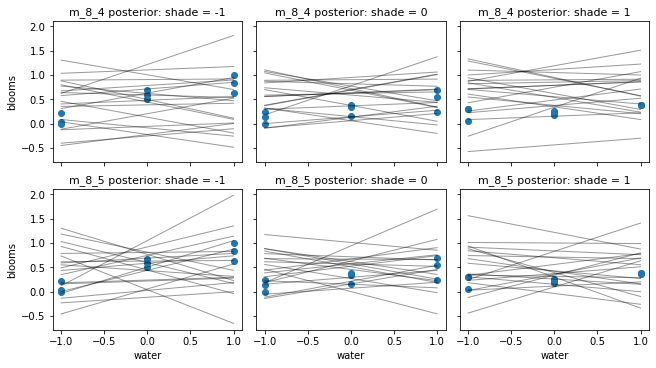

In [40]:
triptych_plot((m_8_4_priors, m_8_5_priors))

#### Since the lines are so scattered, the priors are not very informative. What can we say about these priors, overall? They are harmless, but only weakly realistic. Most of the lines stay within the valid outcome space. But silly trends are not rare. We could do better. We could also do a lot worse, such as flat priors which would consider plausible that even a tiny increase in shade would kill all the tulips. If you displayed these priors to your colleagues, a reasonable summary might be, “These priors contain no bias towards positive or negative effects, and at the same time they very weakly bound the effects to realistic ranges.”